# Setup

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

#pytorch libraries

#other libraries
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

cuda


# Loading the data into a dataset class

In [2]:
pokemon_info = pd.read_csv('../datasets/processed/pokemon.csv')
pokemon_info.head()

,name,image,type1,type2,dex
0,bulbasaur,../datasets/raw/renders_2d/images/1.png,grass,poison,1
1,ivysaur,../datasets/raw/renders_2d/images/2.png,grass,poison,2
2,venusaur,../datasets/raw/renders_2d/images/3.png,grass,poison,3
3,charmander,../datasets/raw/renders_2d/images/4.png,fire,NaN,4
4,charmeleon,../datasets/raw/renders_2d/images/5.png,fire,NaN,5


## OneHot encoding the Types

In [3]:
def onehot(df):
    """Use df to:
     - Create unique list of pokemon types
     - Loop through Type1 and Type2 column
     - Create one-hot encoding for each type
     - Return one-hot encoding for each type as numpy array"""

    all_types = df['type1'].to_list() + df['type2'].to_list()
    uniques = list(set(all_types))
    uniques = [ x for x in uniques if isinstance(x, str) ] # remove nan by keeping only strings
    
    onehot = np.zeros((len(df), len(uniques)))
    for i, row in df.iterrows():
        type1 = row['type1']
        type2 = row['type2']

        # only work with non nan
        if isinstance(type1, str):
            onehot[i, uniques.index(type1)] = 1
        if isinstance(type2, str):
            onehot[i, uniques.index(type2)] = 1

    return onehot, uniques

In [4]:
onehot_enc, uniques = onehot(pokemon_info)
print(onehot_enc)
print(uniques)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
['water', 'normal', 'grass', 'steel', 'fighting', 'fire', 'electric', 'psychic', 'ghost', 'dark', 'rock', 'bug', 'fairy', 'ice', 'poison', 'dragon', 'flying', 'ground']


In [5]:
onehot_enc

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

Helper function for showing a pokemon and its name and types

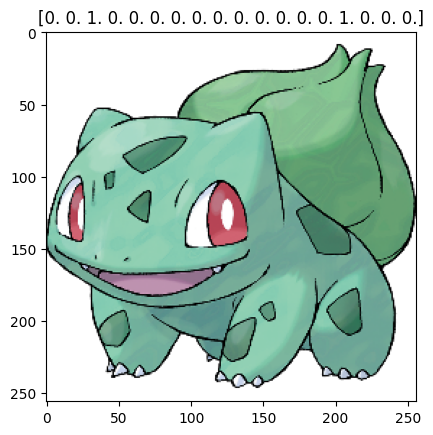

In [6]:
def show_pokemon(image, types):
    """Show image with name, types and evolution of pokemon"""
    plt.imshow(image)
    plt.title(str(types))
    plt.pause(0.001)  # pause a bit so that plots are updated

show_pokemon(Image.open(pokemon_info['image'][0]),
               onehot_enc[0])

In [7]:
class PokemonDataset(Dataset):
    """Pokemon dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pokemon_info = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pokemon_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # img_name = os.path.join(self.root_dir, str(idx+1) + '.png')
        img_name = self.pokemon_info['image'][idx]
        image = Image.open(img_name).convert('RGB')
        # image = np.asarray(image)

        # onehot encode the types
        # sample = {'image': image, 'types': onehot_enc[idx]}

        if self.transform:
            image = self.transform(image)

        return image, onehot_enc[idx]

Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

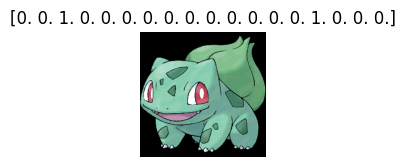

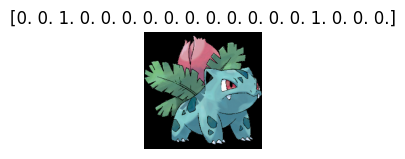

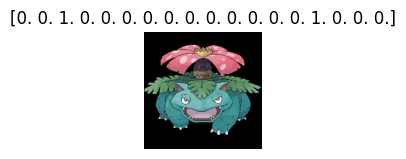

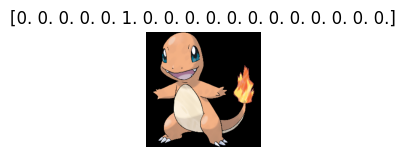

In [8]:
pokemon_dataset = PokemonDataset(csv_file='../datasets/processed/pokemon.csv',
                                 root_dir='../datasets/raw/renders_2d/images/')

fig = plt.figure()

for i, (image, types) in enumerate(pokemon_dataset):

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pokemon(image, types)

    if i == 3:
        plt.show()
        break

# Transform to Tensors

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [10]:
transformed_dataset = PokemonDataset(csv_file='../datasets/processed/pokemon.csv',
                                     root_dir='../datasets/raw/renders_2d/images/',
                                     transform=transform)

for i, (image, types) in enumerate(transformed_dataset):
    print(i, image.size())
    if i == 0:
        break

0 torch.Size([3, 224, 224])


# Save dataloader and encoding mappings

In [11]:
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [0.9, 0.1])

In [18]:
train_loader = DataLoader(train_set, batch_size=16,
                        shuffle=True, num_workers=2)

val_loader = DataLoader(val_set, batch_size=16,
                        shuffle=False, num_workers=2)


In [19]:
for (image, types) in train_loader:
    print(image.size())
    print(image.size())
    break

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


In [20]:
from torchvision.models import VisionTransformer

vit = VisionTransformer(
    image_size = 224, 
    patch_size = 16,
    num_classes = 150528,
    hidden_dim = 768//32,
    mlp_dim = 768//16,
    num_heads = 1,
    num_layers = 4,
    dropout = 0.0,
    attention_dropout = 0.0
)

In [22]:

vit.to(device)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(vit.parameters(), lr=5e-5)

In [23]:
#training process

epochs = 500
outputs = []

loss_list = []
 

for epoch in range(1,epochs+1):
    loss_avg = 0
    for i, data in enumerate(train_loader, start=1):
        
        images, _ = data
        images = images.to(device)
        # print(images.shape)
        
        recon = vit(images)
        # print(recon.shape)
        
        recon = recon.reshape(-1, 3, 224, 224)
        
        loss = loss_fn(recon, images)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_avg += loss.item()
    loss_avg = loss_avg / len(train_loader)
    loss_list.append(loss_avg)
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss_avg:.4f}')  
    outputs.append((epoch, images, recon))

Epoch [10/500], Loss: 0.0795
Epoch [20/500], Loss: 0.0699
Epoch [30/500], Loss: 0.0670
Epoch [40/500], Loss: 0.0632
Epoch [50/500], Loss: 0.0614
Epoch [60/500], Loss: 0.0589
Epoch [70/500], Loss: 0.0560
Epoch [80/500], Loss: 0.0546
Epoch [90/500], Loss: 0.0536
Epoch [100/500], Loss: 0.0528
Epoch [110/500], Loss: 0.0520
Epoch [120/500], Loss: 0.0515
Epoch [130/500], Loss: 0.0507
Epoch [140/500], Loss: 0.0503
Epoch [150/500], Loss: 0.0496
Epoch [160/500], Loss: 0.0491
Epoch [170/500], Loss: 0.0489
Epoch [180/500], Loss: 0.0485
Epoch [190/500], Loss: 0.0482
Epoch [200/500], Loss: 0.0479
Epoch [210/500], Loss: 0.0477
Epoch [220/500], Loss: 0.0475
Epoch [230/500], Loss: 0.0471
Epoch [240/500], Loss: 0.0470
Epoch [250/500], Loss: 0.0467
Epoch [260/500], Loss: 0.0464
Epoch [270/500], Loss: 0.0461
Epoch [280/500], Loss: 0.0458
Epoch [290/500], Loss: 0.0457
Epoch [300/500], Loss: 0.0455
Epoch [310/500], Loss: 0.0453
Epoch [320/500], Loss: 0.0451
Epoch [330/500], Loss: 0.0449
Epoch [340/500], Lo

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 5.78 GiB of which 6.88 MiB is free. Including non-PyTorch memory, this process has 5.77 GiB memory in use. Of the allocated memory 4.82 GiB is allocated by PyTorch, and 833.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
for i, data in enumerate(val_loader):
    (images, labels) = data
    # fire_type = torch.tensor(onehot_enc[3])
    # test_labels = fire_type.repeat(8, 1)
    # test_labels.to(device)
    images, labels = images.to(device), labels.to(device)
    print(images.shape)
    # images_reshaped = images.reshape(-1, 32*32)
    recon = vit(images).to(device)
    recon = recon.reshape(-1, 3, 224, 224)
    break
fig, ax = plt.subplots(4, 2, figsize=(10,10))
for i in range(4):
    ax[i,0].imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[i,1].imshow(recon[i].permute(1, 2, 0).cpu().detach().numpy())
plt.tight_layout()

torch.Size([16, 3, 224, 224])


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 5.78 GiB of which 4.88 MiB is free. Including non-PyTorch memory, this process has 5.77 GiB memory in use. Of the allocated memory 4.82 GiB is allocated by PyTorch, and 833.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF